# Context

The dataset contains data from two different hotels. One Resort hotel and one City hotel.

From the publication (https://www.sciencedirect.com/science/article/pii/S2352340918315191) we know that both hotels are located in Portugal (southern Europe) ("H1 at the resort region of Algarve and H2 at the city of Lisbon"). The distance between these two locations is ca. 280 km by car and both locations border on the north atlantic.

The data contains "bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017".

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import folium

In [ ]:
data= pd.read_csv("/content/hotel_bookings.csv")

In [ ]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# **Data Cleaning and Wrangling**

In [ ]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

- Children feature will be complete with zeros
- Agent and Company feature: if there's not agency, booking was made by the guest probably. It will be complete with zero
- If I don't know the contry, I can't do much. I will eleminate the rows

In [ ]:
nulos={"children":0.0,"agent":0,"company":0,"country":"Unknown"}

In [ ]:
data_clean=data.fillna(nulos)

In [ ]:
data_clean.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

If we check the features, we would realize that MEAL has values ​​such as Undefinied. The data tells us that Undefinied should be abbreviated as SC, so let's do that.

In [ ]:
data_clean["meal"].replace("Undefined","SC",inplace=True)

If we check the features, we also see rows with 0 adults, 0 children and 0 babies. That's absurd. We will eliminate them


In [ ]:
data_clean[(data_clean["adults"]==0)].shape

(403, 32)

Esto no tiene sentido, borremoslas

In [ ]:
data_clean1=data_clean[(data_clean["adults"]!=0 & (data_clean["children"]!=0)& (data_clean["babies"]!=0))]

In [ ]:
data_clean1.shape

(118987, 32)

# **EDA**

## Where are the guests from?

In [ ]:
countries= data_clean1["country"].value_counts()
top15=countries.head(15)

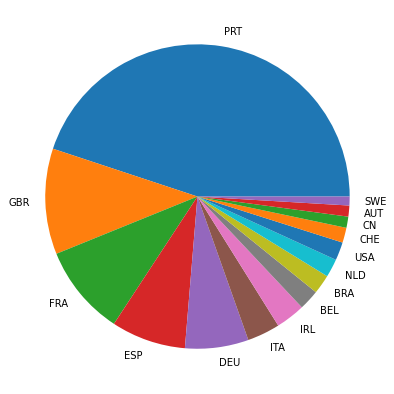

In [ ]:
grafica= plt.figure(figsize=(10,7))
plt.pie(top15,labels=top15.keys(),)
plt.show()

## How much do guests pay for a room one night?

Well, we haven't the room price, but we have ADR, the Average Daily Rate. That is, the average daily rate per room. It is a metric that is used in the hospitality industry. ADR is calculated = (total earnings obtained for all the rooms) / (total number of rooms). So, I divide everything that I earn by the rooms, then it gives me an approximate amount of how much each room comes out.


What can I do with this adr? Well, although I know how much each room costs, I don't know how much it costs per person. So, we are going to divide adr between adults and children (because children are also a payment, babies are not).

In [ ]:
data_clean1["pricePerPerson"] = data_clean1["adr"] / (data_clean1["adults"] + data_clean1["children"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print("""
Resort hotel: {:.2f} € per night and person.
City hotel: {:.2f} € per night and person."""
      .format((data_clean1[(data_clean1["hotel"]=="Resort Hotel")])['pricePerPerson'].mean(),(data_clean1[(data_clean1["hotel"]=="City Hotel")])['pricePerPerson'].mean()))


Resort hotel: 48.48 € per night and person.
City hotel: 58.54 € per night and person.


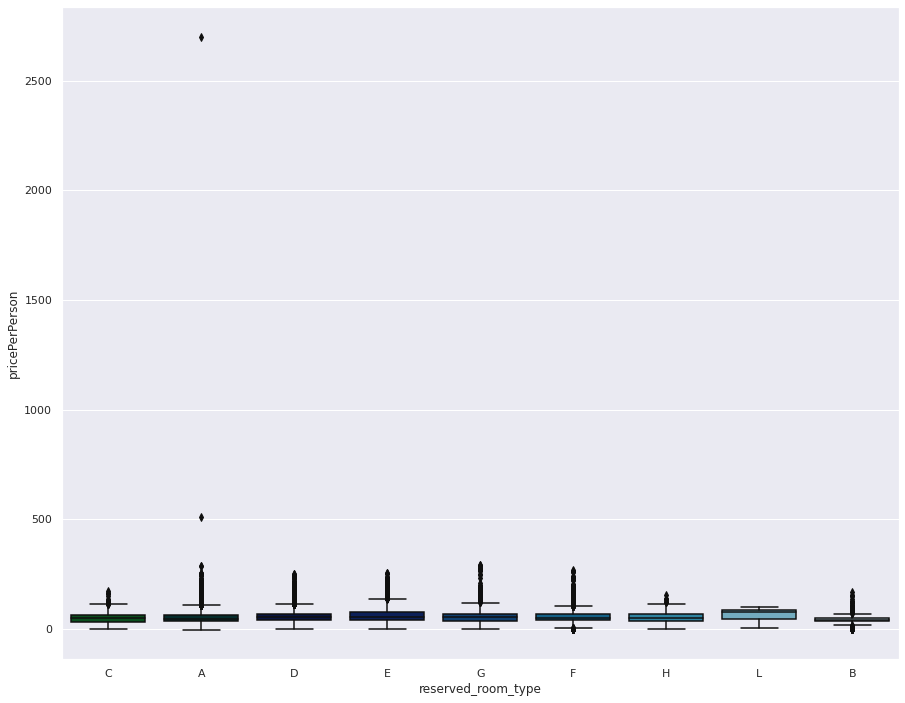

In [ ]:
sns.set(rc={'figure.figsize':(15,12)})
sns.boxplot(x="reserved_room_type",y="pricePerPerson",data=data_clean1,palette="ocean")

We have outliers, lets check it...

In [ ]:
data_clean1[(data_clean1["pricePerPerson"]>500)]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,pricePerPerson
48515,City Hotel,1,35,2016,March,13,25,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,12.0,0.0,0,Transient,5400.0,0,0,Canceled,2016-02-19,2700.0
111403,City Hotel,0,0,2017,May,19,9,0,1,1,0.0,0,BB,ITA,Offline TA/TO,TA/TO,0,0,0,A,G,0,No Deposit,159.0,0.0,0,Transient,510.0,0,0,Check-Out,2017-05-10,510.0


[(0.0, 200.0)]

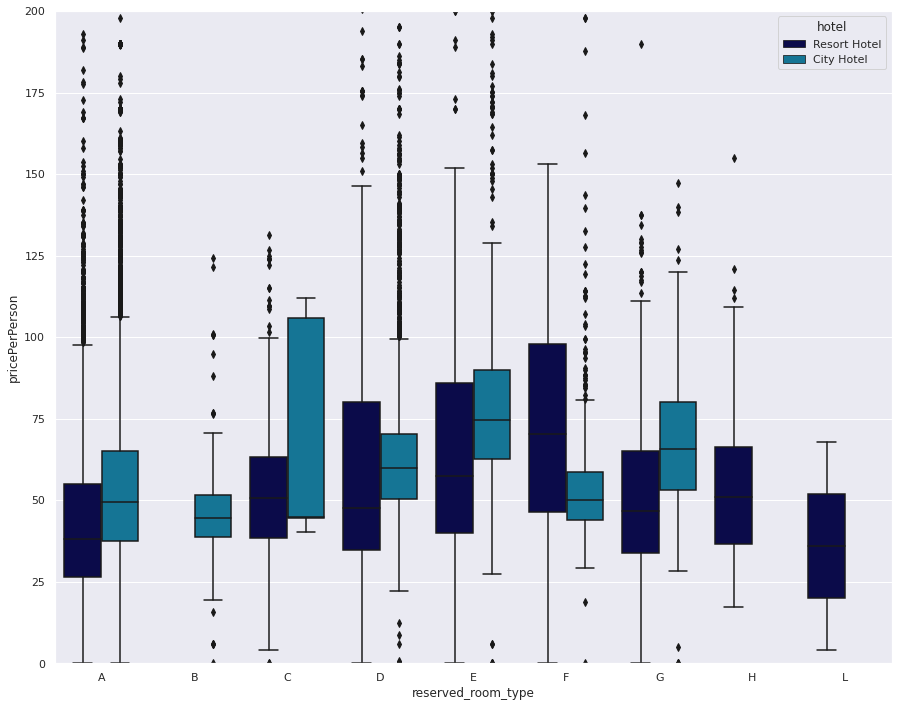

In [ ]:
sns.set(rc={'figure.figsize':(15,12)})
sns.boxplot(x="reserved_room_type",y="pricePerPerson", hue="hotel",data=data_clean1[(data_clean1["is_canceled"]!=0)].sort_values("reserved_room_type"),palette="ocean").set(ylim=(0, 200))

## How does the price per night vary throughout the year?

In [ ]:
months=["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

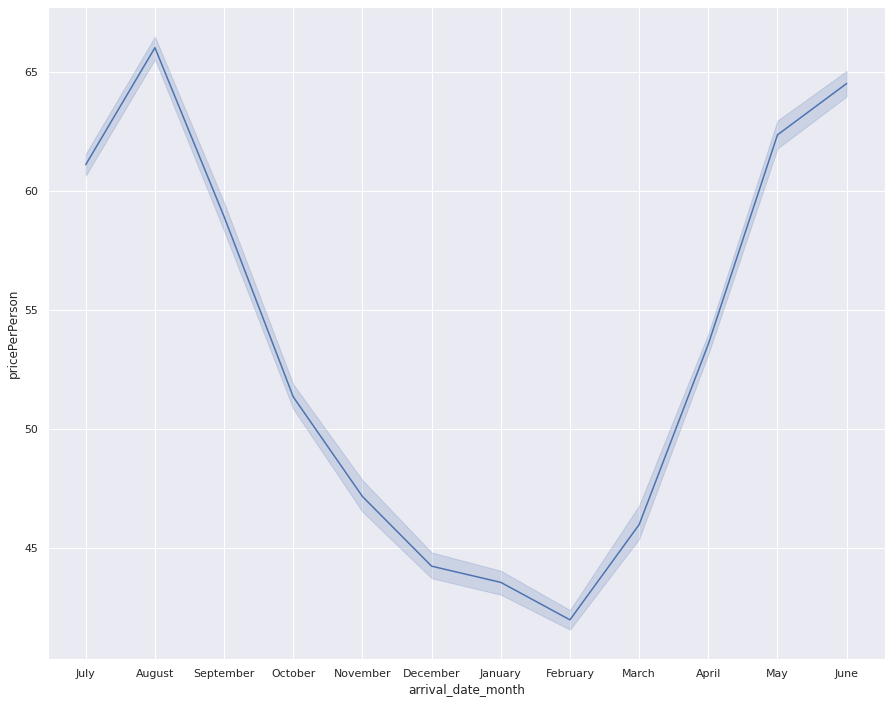

In [ ]:
sns.lineplot(x="arrival_date_month",y="pricePerPerson",data=data_clean1,markers=True)

### Months with more guests

In [ ]:
data_clean1["totalGuest"]=data_clean1["adults"]+data_clean1["children"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print(data_clean1[(data_clean1["arrival_date_year"]==2015)].groupby("arrival_date_month")["arrival_date_month"].count())
print(" ")
print(data_clean1[(data_clean1["arrival_date_year"]==2016)].groupby("arrival_date_month")["arrival_date_month"].count())
print(" ")
print(data_clean1[(data_clean1["arrival_date_year"]==2017)].groupby("arrival_date_month")["arrival_date_month"].count())

perMonth= data_clean1.groupby("arrival_date_month")["arrival_date_month"].count()

arrival_date_month
August       3879
December     2904
July         2774
November     2337
October      4949
September    5109
Name: arrival_date_month, dtype: int64
 
arrival_date_month
April        5417
August       5030
December     3832
February     3871
January      2238
July         4542
June         5282
March        4809
May          5467
November     4428
October      6182
September    5380
Name: arrival_date_month, dtype: int64
 
arrival_date_month
April       5640
August      4920
February    4163
January     3665
July        5295
June        5635
March       4942
May         6297
Name: arrival_date_month, dtype: int64


We just discovered something in the data. For the years 2015 and 2017, there is no information about some months!

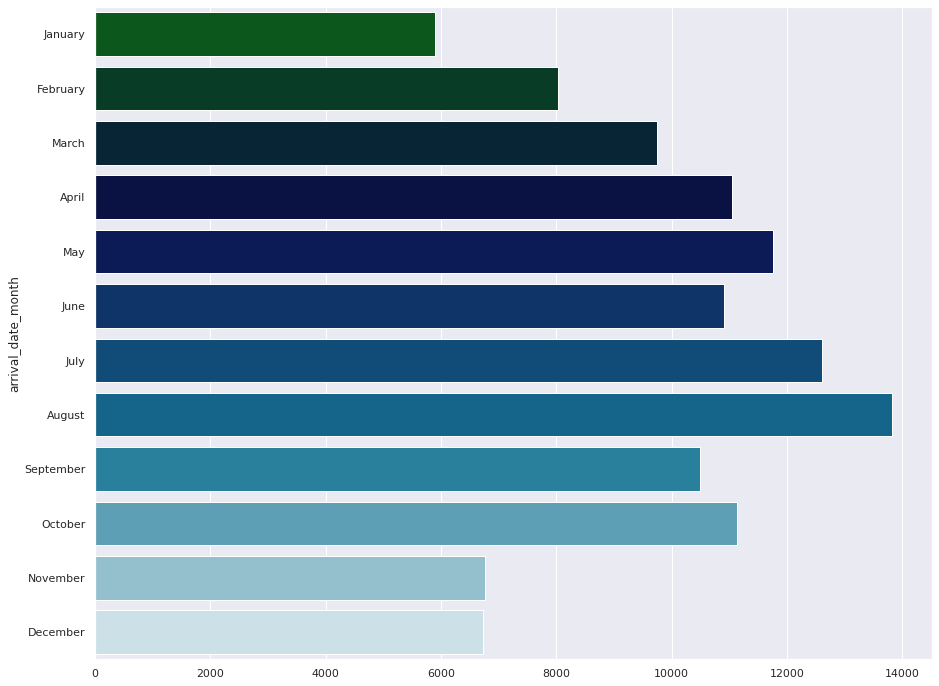

In [ ]:
sns.barplot(x=perMonth.values,
          y=perMonth.keys(),order=["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"],palette="ocean")

## Market segmentation

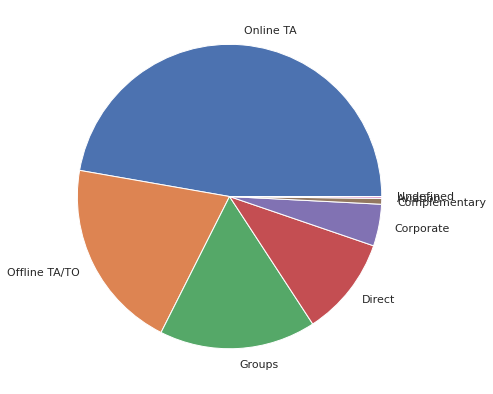

In [ ]:
grafica= plt.figure(figsize=(10,7))
plt.pie(data_clean1["market_segment"].value_counts(),labels=data_clean1["market_segment"].value_counts().keys())
plt.show()

## How long do people stay in hotels?

In [ ]:
data_clean1["total_nights"] = data_clean1["stays_in_weekend_nights"] + data_clean1["stays_in_week_nights"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



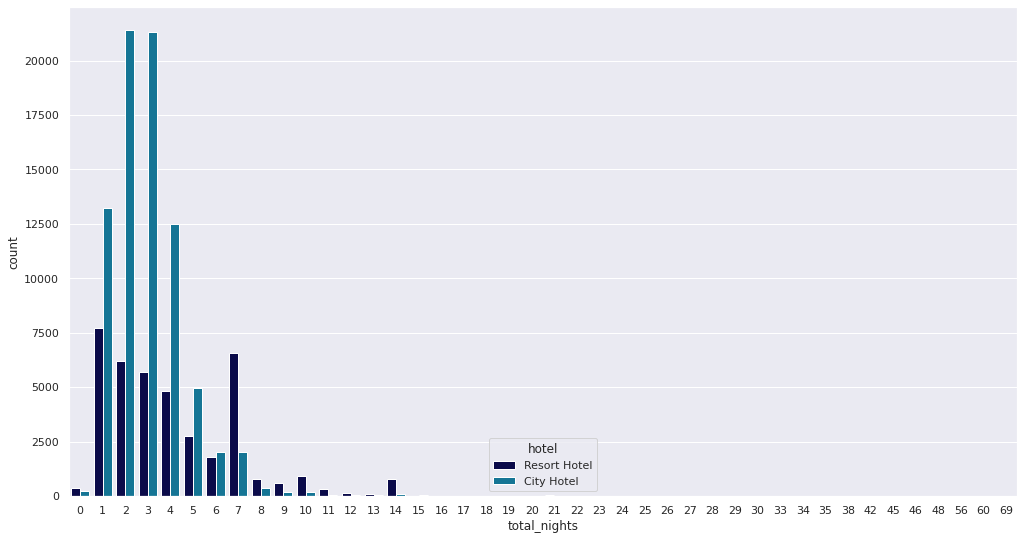

In [ ]:
sns.set(rc={'figure.figsize':(17,9)})
sns.countplot(x="total_nights",data=data_clean1,palette="ocean",hue="hotel")

## How many cancellations were there?

In [ ]:
total_cancelations = data_clean1.groupby("arrival_date_month")["is_canceled"].sum()
total_cancelations

arrival_date_month
April        4510
August       5226
December     2359
February     2687
January      1802
July         4727
June         4531
March        3137
May          4669
November     2115
October      4244
September    4108
Name: is_canceled, dtype: int64

In [ ]:
total_cancelations.keys()

Index(['April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September'],
      dtype='object', name='arrival_date_month')

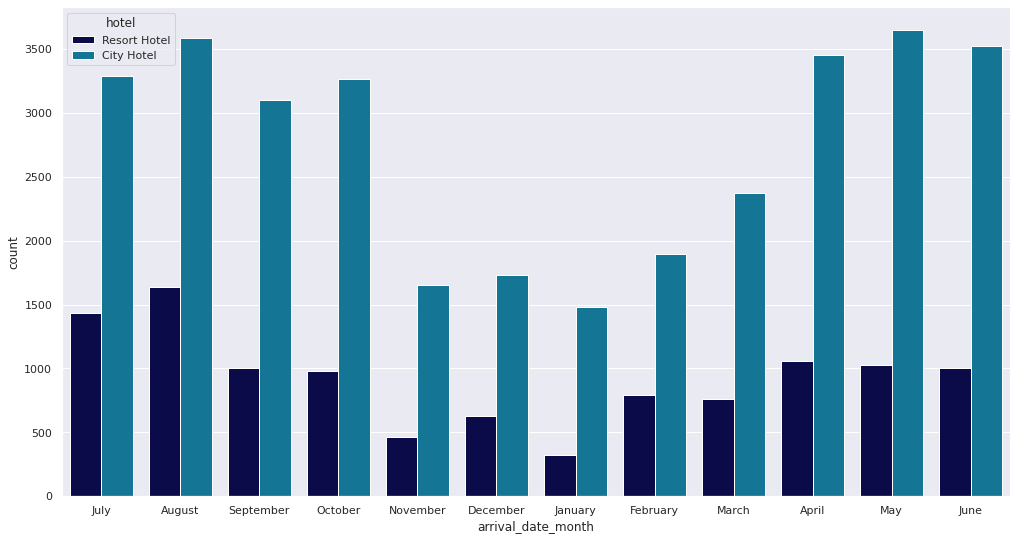

In [ ]:
sns.countplot(x="arrival_date_month",hue="hotel",data=data_clean1[(data_clean1.is_canceled==1)],palette="ocean")

## Correlation

In [ ]:
cancel_corr = data_clean1.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.292983
total_of_special_requests         0.235262
required_car_parking_spaces       0.195863
booking_changes                   0.144863
previous_cancellations            0.110222
is_repeated_guest                 0.083797
company                           0.083675
adults                            0.058891
previous_bookings_not_canceled    0.057413
days_in_waiting_list              0.054357
totalGuest                        0.049937
agent                             0.046814
adr                               0.046460
babies                            0.032620
stays_in_week_nights              0.025348
total_nights                      0.018382
pricePerPerson                    0.017788
arrival_date_year                 0.016450
arrival_date_week_number          0.008323
arrival_date_day_of_month         0.005878
children                          0.004837
stays_in_weekend_nights           0.001388
Name: is_canceled, dtype: float64

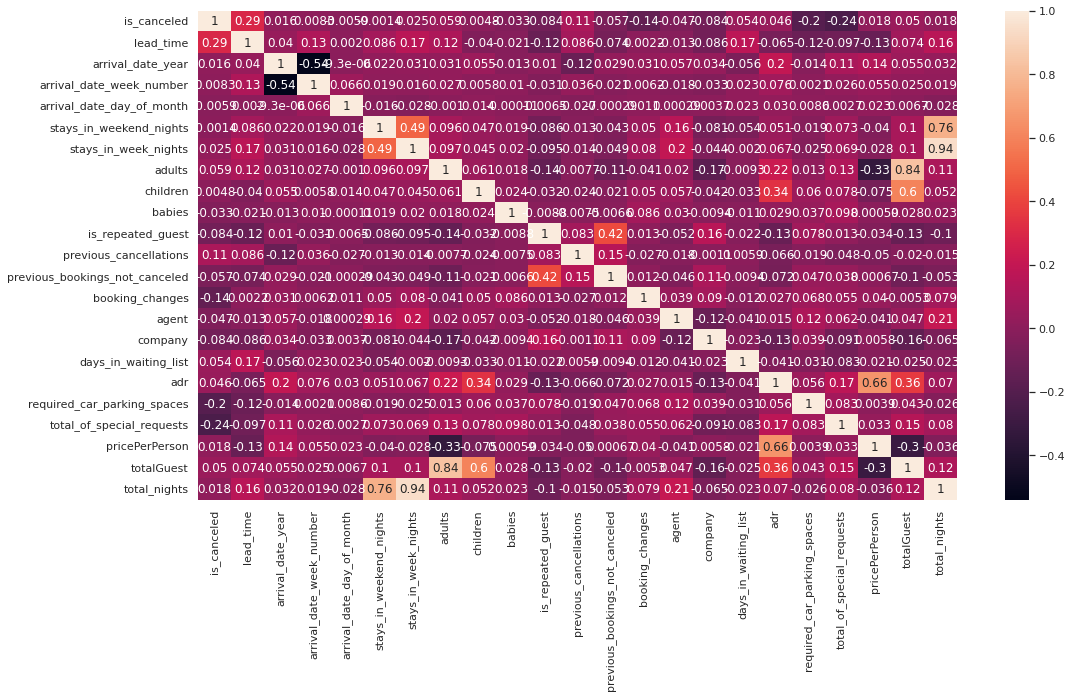

In [ ]:
sns.heatmap(data_clean1.corr(),annot=True)

## Model

In [ ]:
from sklearn.model_selection import train_test_split

seed=777

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier


lr = LogisticRegression(n_jobs = -1)
knn = KNeighborsClassifier(n_jobs= -1)
rf = RandomForestClassifier()
xgb = XGBClassifier(n_jobs = -1)
gb=GradientBoostingClassifier()
abc=AdaBoostClassifier()

In [ ]:
X= data_clean1[["total_of_special_requests", "lead_time","required_car_parking_spaces","booking_changes","previous_cancellations","is_repeated_guest"]]
Y=data_clean1.is_canceled
X.head()

,total_of_special_requests,lead_time,required_car_parking_spaces,booking_changes,previous_cancellations,is_repeated_guest
0,0,342,0,3,0,0
1,0,737,0,4,0,0
2,0,7,0,0,0,0
3,0,13,0,0,0,0
4,1,14,0,0,0,0


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [ ]:
#Por defecto el metodo score retorna el coeficiente de determinacion R^2
def entrenar(model):
    model.fit(X_train, y_train)
    return (model.score(X_train, y_train),model.score(X_test, y_test))
    #return model.score(X_test, y_test)

#Entrenamos
modelos = {'LogisticRegression': lr,
          'KNeighborsClassifier': knn,
          'RandomForestClassifier': rf,
          'XGBClassifier': xgb,
          'GradientBoostingClassifier': gb,
          'AdaBoostClassifier': abc}
scores={}
train_scores={}
for nombre, modelo in modelos.items():
    scores[nombre]=entrenar(modelo)[1]
    train_scores[nombre]=entrenar(modelo)[0]

scores.items()

dict_items([('LogisticRegression', 0.7187998991511891), ('KNeighborsClassifier', 0.7315740818556181), ('RandomForestClassifier', 0.7573325489536936), ('XGBClassifier', 0.7472476678712496), ('GradientBoostingClassifier', 0.7472476678712496), ('AdaBoostClassifier', 0.7430036137490545)])

In [ ]:
scores = pd.DataFrame(scores,index=['Score']).transpose()
scores = scores.sort_values('Score')

train_scores = pd.DataFrame(train_scores,index=['Train Score']).transpose()
train_scores = train_scores.sort_values('Train Score')

cm = sns.color_palette('flare',as_cmap=True)

Train score

In [ ]:
train_scores.style.background_gradient(cmap=cm)

,Train Score
LogisticRegression,0.718739
KNeighborsClassifier,0.743069
AdaBoostClassifier,0.745622
XGBClassifier,0.748952
GradientBoostingClassifier,0.749047
RandomForestClassifier,0.775447


Test score

In [ ]:
scores = scores.style.background_gradient(cmap=cm)
scores

,Score
LogisticRegression,0.718800
KNeighborsClassifier,0.731574
AdaBoostClassifier,0.743004
XGBClassifier,0.747248
GradientBoostingClassifier,0.747248
RandomForestClassifier,0.757333
